# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

## Classificação de Sentenças com CNNs e TensorFlow
[Paper](https://arxiv.org/pdf/1408.5882.pdf): Convolutional Neural Networks for Sentence Classification by Yoon Kim

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


Embora as CNNs tenham sido usadas principalmente para tarefas de Visão Computacional, nada as impede de serem usadas em aplicativos de PLN. Uma dessas aplicações para as quais as CNNs têm sido usadas efetivamente é a classificação de sentenças. 

Na classificação da sentenças, uma dada sentença deve ser classificada em uma classe (categoria). Usaremos um banco de dados de perguntas, onde cada pergunta é rotulada pelo assunto da pergunta. Por exemplo, a pergunta "Quem foi Abraham Lincoln?" será uma pergunta e seu rótulo será Pessoa. Para isso, usaremos um conjunto de dados de classificação de frases disponível em http://cogcomp.org/Data/QA/QC/; aqui você encontrará mil sentenças de treinamento e seus respectivos rótulos e 500 sentenças de teste.

Categorias: http://cogcomp.org/Data/QA/QC/definition.html

Referência:

http://www.deeplearningbook.com.br/

In [2]:
!nvidia-smi

Fri May 22 17:43:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   36C    P8     9W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Imports
import os
import math
import random
import zipfile
import collections
import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pylab
%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

tensorflow       2.2.0
matplotlib       3.2.1
matplotlib.pylab 1.18.4
numpy            1.18.4
Data Science Academy


In [6]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Verificando o Dataset

Usaremos o Dataset: http://cogcomp.cs.illinois.edu/Data/QA/QC/ que é composto de perguntas como entradas e seu respectivo tipo como saída. Por exemplo: quem era Abraham Lincon? E a saída ou rótulo seria Humano.

In [7]:
# Diretório
dir_name = 'question-classif-data'

# Dataset de treino
filename = dir_name + 'train_1000.label'

# Dataset de teste
test_filename = dir_name +  'TREC_10.label'

In [8]:
# Verifica se os arquivos existem
filenames = ['train_1000.label','TREC_10.label']
num_files = len(filenames)
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists
print('Arquivos encontrados e verificados!')

Arquivos encontrados e verificados!


## Carregando e Pré-Processando os Dados

Abaixo nós carregamos o texto e fazemos um pré-processamento!

Considere por exemplo que tenhamos 3 frases:

- Bob and Mary are friends.
- Bob plays soccer.
- Mary likes to sing in the choir.

Nossa matriz de sentenças ficaria assim, considerando o padding (ajuste para frases mais curtas)

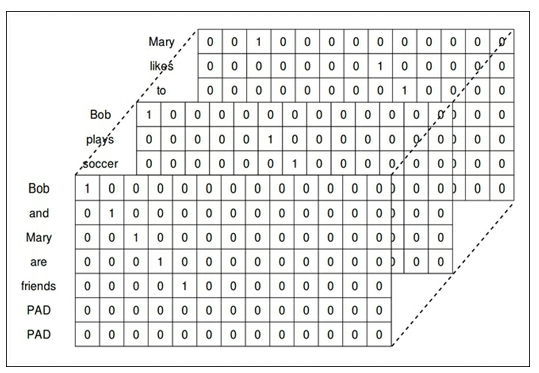

In [9]:
from IPython.display import Image
Image("images/matrix.png")

In [10]:
# Grava o tamanho máximo das sentenças, pois precisamos preencher sentenças menores de acordo
max_sent_length = 0

# Função para leitura dos dados
def read_data(filename):
    '''
    Ler dados de um arquivo com nome de arquivo dado
    Retornar uma lista de strings em que cada string é uma palavra minúscula
    '''
    global max_sent_length
    questions = []
    labels = []
    with open(filename,'r',encoding='latin-1') as f:
        for row in f:
            row_str = row.split(":")
            lb,q = row_str[0],row_str[1]
            q = q.lower()
            labels.append(lb)
            questions.append(q.split())
            if len(questions[-1]) > max_sent_length:
                max_sent_length = len(questions[-1])
    return questions,labels

In [11]:
# Processa os dados de treino e de teste
for i in range(num_files):
    print('\nProcessando o Arquivo %s'%os.path.join(dir_name,filenames[i]))
    if i==0:
        # Processando os dados de treino
        train_questions,train_labels = read_data(os.path.join(dir_name,filenames[i]))
        # Certificando-se de que recebemos todas as perguntas e etiquetas correspondentes
        assert len(train_questions)==len(train_labels)
    elif i==1:
        # Processando os dados de teste
        test_questions,test_labels = read_data(os.path.join(dir_name,filenames[i]))
        # Certificando-se de que recebemos todas as perguntas e etiquetas correspondentes
        assert len(test_questions)==len(test_labels)

    # Imprima alguns dados para ver que tudo está bem
    for j in range(5):
        print('\n\tQuestão %d: %s' %(j,train_questions[j]))
        print('\tLabel %d: %s\n'%(j,train_labels[j]))

print('Max Sentence Length: %d'%max_sent_length)
print('\nNormalizando todas as sentenças para o mesmo comprimento')


Processando o Arquivo question-classif-data/train_1000.label

	Questão 0: ['manner', 'how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?']
	Label 0: DESC


	Questão 1: ['cremat', 'what', 'films', 'featured', 'the', 'character', 'popeye', 'doyle', '?']
	Label 1: ENTY


	Questão 2: ['manner', 'how', 'can', 'i', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?']
	Label 2: DESC


	Questão 3: ['animal', 'what', 'fowl', 'grabs', 'the', 'spotlight', 'after', 'the', 'chinese', 'year', 'of', 'the', 'monkey', '?']
	Label 3: ENTY


	Questão 4: ['exp', 'what', 'is', 'the', 'full', 'form', 'of', '.com', '?']
	Label 4: ABBR


Processando o Arquivo question-classif-data/TREC_10.label

	Questão 0: ['manner', 'how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?']
	Label 0: DESC


	Questão 1: ['cremat', 'what', 'films', 'featured', 'the', 'character', 'popeye', 'doyle', '?']
	Label 1: ENTY


	Questão 2: ['manner', 'how', 'can', 'i',

## Padding de Sentenças Curtas
Usamos padding para preencher frases curtas para que todas as sentenças tenham o mesmo tamanho.

In [12]:
# Padding dos dados de treino
for qi,que in enumerate(train_questions):
    for _ in range(max_sent_length-len(que)):
        que.append('PAD')
    assert len(que)==max_sent_length
    train_questions[qi] = que
print('\nQuestões de treino padded')

# Padding dos dados de teste
for qi,que in enumerate(test_questions):
    for _ in range(max_sent_length-len(que)):
        que.append('PAD')
    assert len(que)==max_sent_length
    test_questions[qi] = que
print('\nQuestões de teste padded')

# Imprimindo uma questão de teste para ver se tudo está correto
print('\nAmostra de questões de teste:\n\n', test_questions[0])


Questões de treino padded

Questões de teste padded

Amostra de questões de teste:

 ['dist', 'how', 'far', 'is', 'it', 'from', 'denver', 'to', 'aspen', '?', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


## Construindo os Dicionários
Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia um ID para uma palavra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras (i.e. [0, 1, 2, 3, 2, 4])

Nós não substituímos palavras raras por "UNK" porque o vocabulário já é bem pequeno.

In [13]:
def build_dataset(questions):
    words = []
    data_list = []
    count = []

    # Primeiro criamos uma lista grande com todas as palavras em todas as perguntas
    for d in questions:
        words.extend(d)
    print('%d Palavras encontradas.'%len(words))
    print('Encontradas %d palavras no vocabulário. '%len(collections.Counter(words).most_common()))

    # Ordenar palavras por frequência
    count.extend(collections.Counter(words).most_common())

    # Criar um ID para cada palavra, dando o tamanho atual do dicionário e adicionando esse item ao dicionário
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    # Atravessar todo o texto e substituir as palavras da string pelo ID da palavra encontrada nesse índice
    for d in questions:
        data = list()
        for word in d:
            index = dictionary[word]
            data.append(index)

        data_list.append(data)

    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data_list, count, dictionary, reverse_dictionary

# Cria um conjunto de dados com perguntas de treino e teste
all_questions = list(train_questions)
all_questions.extend(test_questions)

# Use o conjunto de dados criado acima para construir o vocabulário
all_question_ind, count, dictionary, reverse_dictionary = build_dataset(all_questions)

# Print some statistics about the processed data
print('Todas as palavras (count)', count[:5])
print('\nDados de Amostra', all_question_ind[0])
print('\nDados de Amostra', all_question_ind[1])
print('\nVocabulário: ',len(dictionary))
vocabulary_size = len(dictionary)

print('\nNúmero de questões de treinamento: ',len(train_questions))
print('Número de questões de teste: ',len(test_questions))

49500 Palavras encontradas.
Encontradas 3369 palavras no vocabulário. 
Todas as palavras (count) [('PAD', 34407), ('?', 1454), ('the', 999), ('what', 963), ('is', 587)]

Dados de Amostra [38, 12, 19, 1006, 1007, 6, 28, 1008, 1009, 544, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Dados de Amostra [44, 3, 545, 1010, 2, 163, 1011, 1012, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Vocabulário:  3369

Número de questões de treinamento:  1000
Número de questões de teste:  500


## Gerando lotes de dados

Abaixo, o código para gerar um lote de dados de um determinado conjunto de perguntas e rótulos.

In [14]:
# Nós processamos 16 perguntas de cada vez
batch_size = 16
sent_length = max_sent_length

# Número de classes
num_classes = 6

# Todos os tipos de pergunta que estão no conjunto de dados
# http://cogcomp.org/Data/QA/QC/definition.html
all_labels = ['NUM','LOC','HUM','DESC','ENTY','ABBR']

class BatchGenerator(object):
    def __init__(self,batch_size,questions,labels):
        self.questions = questions
        self.labels = labels
        self.text_size = len(questions)
        self.batch_size = batch_size
        self.data_index = 0
        assert len(self.questions)==len(self.labels)

    def generate_batch(self):
        '''
        Função de geração de dados. Isso gera duas matrizes
        inputs: um lote de perguntas em que cada questão é um tensor de tamanho
        [sent_length, vocabulary_size] com cada palavra one-hot encoded
        labels_ohe: rótulos codificados com one-hot correspondentes às questões de entradas
        '''
        global sent_length,num_classes
        global dictionary, all_labels

        # Matrizes Numpy com dados de entrada e etiqueta
        inputs = np.zeros((self.batch_size,sent_length,vocabulary_size),dtype=np.float32)
        labels_ohe = np.zeros((self.batch_size,num_classes),dtype=np.float32)

        # Quando chegamos ao fim do conjunto de dados, voltamos ao começo
        if self.data_index + self.batch_size >= self.text_size:
            self.data_index = 0

        # Para cada pergunta no conjunto de dados
        for qi,que in enumerate(self.questions[self.data_index:self.data_index+self.batch_size]):
            # Para cada palavra na pergunta
            for wi,word in enumerate(que):
                # Defina o elemento no índice de ID da palavra como 1,
                # o que dá o vetor codificado com uma dessas palavras
                inputs[qi,wi,dictionary[word]] = 1.0

            # Defina o índice correspondente a essa classe específica para 1
            labels_ohe[qi,all_labels.index(self.labels[self.data_index + qi])] = 1.0

        # Atualize o índice de dados para obter o próximo lote de dados
        self.data_index = (self.data_index + self.batch_size)%self.text_size

        return inputs,labels_ohe

    def return_index(self):
        # Obtenha o índice atual de dados
        return self.data_index

# Teste nosso gerador de lotes
sample_gen = BatchGenerator(batch_size,train_questions,train_labels)

# Gere um único lote
sample_batch_inputs,sample_batch_labels = sample_gen.generate_batch()

# Gere outro lote
sample_batch_inputs_2,sample_batch_labels_2 = sample_gen.generate_batch()

# Certifique-se de que nós infact temos a questão 0 como o 0º elemento do nosso lote
assert np.all(np.asarray([dictionary[w] for w in train_questions[0]],dtype=np.int32)
              == np.argmax(sample_batch_inputs[0,:,:],axis=1))

# Print some data labels we obtained
print('Rótulos de lote de amostra')
print(np.argmax(sample_batch_labels,axis=1))
print(np.argmax(sample_batch_labels_2,axis=1))

Rótulos de lote de amostra
[3 4 3 4 5 2 2 2 3 2 0 3 2 2 4 1]
[3 0 3 3 0 4 2 3 3 4 2 1 4 1 5 4]


## Rede Neural de Convolução Classificadora de Sentença

Vamos implementar uma CNN para classificar sentenças e você verá que, mesmo com essa estrutura simples, obtemos boas precisões. Nossa CNN terá uma camada (com 3 camadas paralelas diferentes). Isso será seguido por uma camada de agrupamento ao longo do tempo e, finalmente, uma camada totalmente conectada que produz os logits.

## Definição de hiperparâmetros e entradas

In [15]:
tf.compat.v1.reset_default_graph()

batch_size = 32

# Diferentes tamanhos de filtro que usamos em uma única camada de convolução
filter_sizes = [3,5,7]

# Inputs e labels
sent_inputs = tf.compat.v1.placeholder(shape=[batch_size,sent_length,vocabulary_size],dtype=tf.float32,name='sentence_inputs')
sent_labels = tf.compat.v1.placeholder(shape=[batch_size,num_classes],dtype=tf.float32,name='sentence_labels')

## Definindo Parâmetros do Modelo

Nosso modelo tem os seguintes parâmetros.
* 3 conjuntos de pesos e vieses da camada de convolução (um para cada camada paralela)
* 1 camada de saída totalmente conectada

In [16]:
# 3 filtros com diferentes tamanhos de janela de contexto (3,5,7)
# Cada um desses filtros abrange o comprimento completo onde-hot encoded de cada palavra e a largura da janela de contexto

# Pesos da primeira camada paralela
w1 = tf.Variable(tf.random.truncated_normal([filter_sizes[0],vocabulary_size,1],stddev=0.02,dtype=tf.float32),name='weights_1')
b1 = tf.Variable(tf.random.uniform([1],0,0.01,dtype=tf.float32),name='bias_1')

# Pesos da segunda camada paralela
w2 = tf.Variable(tf.random.truncated_normal([filter_sizes[1],vocabulary_size,1],stddev=0.02,dtype=tf.float32),name='weights_2')
b2 = tf.Variable(tf.random.uniform([1],0,0.01,dtype=tf.float32),name='bias_2')

# Pesos da terceira camada paralela
w3 = tf.Variable(tf.random.truncated_normal([filter_sizes[2],vocabulary_size,1],stddev=0.02,dtype=tf.float32),name='weights_3')
b3 = tf.Variable(tf.random.uniform([1],0,0.01,dtype=tf.float32),name='bias_3')

# Fully connected layer
w_fc1 = tf.Variable(tf.random.truncated_normal([len(filter_sizes),num_classes],stddev=0.5,dtype=tf.float32),name='weights_fulcon_1')
b_fc1 = tf.Variable(tf.random.uniform([num_classes],0,0.01,dtype=tf.float32),name='bias_fulcon_1')

## Definição de Inferência da CNN

Aqui nós definimos a lógica de inferência da CNN. Primeiro, calculamos a saída da convolução para cada camada paralela dentro da camada de convolução. Em seguida, executamos o agrupamento ao longo do tempo em todas as saídas da convolução. Finalmente, alimentamos a saída da camada de pooling para uma camada totalmente conectada para obter os logits de saída.

In [17]:
# Calcule a saída para todos os filtros com um passo 1
# Usamos relu como a função de ativação
h1_1 = tf.nn.relu(tf.nn.conv1d(input=sent_inputs, filters=w1, stride=1, padding='SAME') + b1)
h1_2 = tf.nn.relu(tf.nn.conv1d(input=sent_inputs, filters=w2, stride=1, padding='SAME') + b2)
h1_3 = tf.nn.relu(tf.nn.conv1d(input=sent_inputs, filters=w3, stride=1, padding='SAME') + b3)

# Pooling ao longo do tempo de operação

# Aqui temos o max pooling. Existem duas opções para fazer o max pooling

# 1. Use a operação tf.nn.max_pool em um tensor feito pela concatenação de h1_1, h1_2, h1_3 e convertendo esse tensor em 4D
# (Porque max_pool pega um tensor de rank >= 4)

# 2. Faça o max pooling separadamente para cada saída de filtro e combine-os usando tf.concat
# (este é o usado no código)

h2_1 = tf.reduce_max(input_tensor=h1_1,axis=1)
h2_2 = tf.reduce_max(input_tensor=h1_2,axis=1)
h2_3 = tf.reduce_max(input_tensor=h1_3,axis=1)

# Pooling ao longo do tempo de operação (Apenas em PLN)
h2 = tf.concat([h2_1,h2_2,h2_3],axis=1)

# Calcule a saída da camada totalmente conectada (sem ativação)
# Nota: desde h2 é 2d [batch_size, número de filtros paralelos]
# remodelar a saída não é necessária, como costuma fazer em CNNs
logits = tf.matmul(h2,w_fc1) + b_fc1

## Função de Perda e Otimizador

Calculamos a perda de entropia cruzada e usamos o otimizador de momentum (que funciona melhor do que o gradiente descendente padrão) para otimizar nosso modelo.

In [18]:
# Loss (Cross-Entropy)
loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=sent_labels,logits=logits))

# Momentum Optimizer
optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=0.01,momentum=0.9).minimize(loss)

## Previsões de modelo

Observe que não estamos obtendo as previsões brutas, mas o índice do elemento máximo ativado no vetor de previsão.

In [19]:
predictions = tf.argmax(input=tf.nn.softmax(logits),axis=1)

## Executando nosso modelo para classificar sentenças

Abaixo nós executamos nosso algoritmo por 75 épocas. Com os hiperparâmetros fornecidos, você deve atingir cerca de 90% de precisão no conjunto de testes. Recomendamos que você tente ajustar os hiperparâmetros e assim tentar obter uma precisão ainda maior.

In [20]:
# Com larguras de filtro [3,5,7] e batch_size 32 o algoritmo
# atinge cerca de ~ 90% de precisão no conjunto de dados de teste (50 epochs).
# De tamanhos de lotes [16,32,64] 32 ofereceu o melhor desempenho

# Inicia sessão
session = tf.compat.v1.InteractiveSession()

# Número de épocas em que o algoritmo é executado
num_steps = 75

# Inicializa todas as variáveis
tf.compat.v1.global_variables_initializer().run()
print('Variáveis Inicializadas\n')

# Definir geradores de lotes de dados para dados de treinamento e teste
train_gen = BatchGenerator(batch_size,train_questions,train_labels)
test_gen = BatchGenerator(batch_size,test_questions,test_labels)

# Quantas vezes calculamos a precisão em teste
test_interval = 1

# Precisão computacional para um determinado conjunto de previsões e rótulos
def accuracy(labels,preds):
    return np.sum(np.argmax(labels,axis=1)==preds)/labels.shape[0]

# Executando o algoritmo
for step in range(num_steps):
    avg_loss = []

    # Uma única travessia ao longo de todo o conjunto de treinamento
    for tr_i in range((len(train_questions)//batch_size)-1):

        # Obter um lote de dados
        tr_inputs, tr_labels = train_gen.generate_batch()

        # Otimiza a rede e calcule a perda
        l,_ = session.run([loss,optimizer],feed_dict={sent_inputs: tr_inputs, sent_labels: tr_labels})
        avg_loss.append(l)

    # Print da perda média
    print('Taxa de erro em treino na Epoch %d: %.2f'%(step,np.mean(avg_loss)))
    test_accuracy = []

    # Calcular a precisão do teste
    if (step+1)%test_interval==0:
        for ts_i in range((len(test_questions)-1)//batch_size):

            # Obter um lote de dados de teste
            ts_inputs,ts_labels = test_gen.generate_batch()

            # Obtenha previsões para esse lote
            preds = session.run(predictions,feed_dict={sent_inputs: ts_inputs, sent_labels: ts_labels})

            # Precisão do teste
            test_accuracy.append(accuracy(ts_labels, preds))

        # Exibe a precisão média em teste
        print('Acurácia em teste na Epoch %d: %.3f'%(step,np.mean(test_accuracy)*100.0))

Variáveis Inicializadas

Taxa de erro em treino na Epoch 0: 1.77
Acurácia em teste na Epoch 0: 31.667
Taxa de erro em treino na Epoch 1: 1.69
Acurácia em teste na Epoch 1: 25.833
Taxa de erro em treino na Epoch 2: 1.64
Acurácia em teste na Epoch 2: 25.625
Taxa de erro em treino na Epoch 3: 1.59
Acurácia em teste na Epoch 3: 28.750
Taxa de erro em treino na Epoch 4: 1.53
Acurácia em teste na Epoch 4: 30.208
Taxa de erro em treino na Epoch 5: 1.46
Acurácia em teste na Epoch 5: 31.667
Taxa de erro em treino na Epoch 6: 1.39
Acurácia em teste na Epoch 6: 32.292
Taxa de erro em treino na Epoch 7: 1.32
Acurácia em teste na Epoch 7: 33.125
Taxa de erro em treino na Epoch 8: 1.24
Acurácia em teste na Epoch 8: 37.083
Taxa de erro em treino na Epoch 9: 1.17
Acurácia em teste na Epoch 9: 38.125
Taxa de erro em treino na Epoch 10: 1.09
Acurácia em teste na Epoch 10: 42.292
Taxa de erro em treino na Epoch 11: 1.03
Acurácia em teste na Epoch 11: 43.958
Taxa de erro em treino na Epoch 12: 0.97
Acurác

In [21]:
# Entradas
ts_inputs

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [22]:
# Labels
# all_labels = ['NUM','LOC','HUM','DESC','ENTY','ABBR']
ts_labels

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0.

In [23]:
# Classificação de sentenças
# all_labels = ['NUM','LOC','HUM','DESC','ENTY','ABBR']
preds

array([0, 4, 4, 4, 4, 0, 1, 1, 4, 1, 3, 3, 2, 4, 4, 0, 1, 4, 3, 2, 3, 3,
       3, 3, 4, 0, 4, 4, 3, 1, 4, 1])

# Fim